# setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
print("sklearn version: ", sklearn.__version__)
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
!pip install tensorflow_addons
import tensorflow_addons as tfa
from tensorflow import keras
print("TF version: ", tf.__version__)
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# GPU test
print("GPU installed: ",tf.test.is_built_with_gpu_support())

# To prevent "CUDNN_STATUS_ALLOC_FAILED" error with GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
    
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")    

from tensorflow.python.keras.utils.data_utils import Sequence

sklearn version:  1.0.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 6.6 MB/s 
TF version:  2.8.0
GPU installed:  True
1 Physical GPUs, 1 Logical GPUs


# Get the data

In [2]:
from google.colab import drive 
drive.mount('/content/drive')
X_train=np.load('drive/MyDrive/Colab Notebooks/datasets/Emnist//X_train.npy')
y_train=np.load('drive/MyDrive/Colab Notebooks/datasets/Emnist//y_train.npy')
X_valid=np.load('drive/MyDrive/Colab Notebooks/datasets/Emnist//X_valid.npy')
y_valid=np.load('drive/MyDrive/Colab Notebooks/datasets/Emnist//y_valid.npy')

Mounted at /content/drive


In [3]:
#황성현
#npy 파일이 존재할 경우 exsitNumpy = True, 없으면 False
X_train.shape,X_train.dtype

((533917, 28, 28), dtype('uint8'))

In [4]:
X_train_letters = X_train[np.where(y_train>10)]

In [5]:
y_train_letters = y_train[np.where(y_train>10)]

In [6]:
for i in range (3):
    X_train = np.append(X_train,X_train_letters,axis=0)
    y_train = np.append(y_train, y_train_letters,axis=0)

In [7]:
X_train.shape

(1329679, 28, 28)

In [8]:
import gc
del X_train_letters, y_train_letters
gc.collect


<function gc.collect>

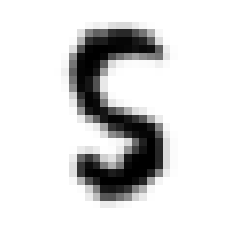

28


In [9]:
import cv2 as cv
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
ids=1
X_new=X_train[ids]
y_new=y_train[ids]
c=X_new.reshape(28,28)


plt.imshow(c, cmap="binary")
plt.axis('off')
plt.show()
print(y_new)

# Prepare the data

In [10]:
#황성현
#data, batch size 성정
train_size=len(X_train)
valid_size=len(X_valid)
batch_size=32
train_size

1329679

In [11]:
#황성현
X_train=np.reshape(X_train,[-1,784])
X_valid=np.reshape(X_valid,[-1,784])
X_train.shape,X_valid.shape

((1329679, 784), (164015, 784))

In [12]:
#황성현
y_train=np.reshape(y_train,[-1,1])
y_valid=np.reshape(y_valid,[-1,1])

y_train.shape,y_valid.shape

((1329679, 1), (164015, 1))

In [13]:
#황성현
n_inputs = X_train.shape[-1]
print("n_inputs =",n_inputs)

n_inputs = 784


In [14]:
#황성현
def save_to_multiple_csv_files(data, name_prefix, header=None, n_parts=10):
    Emnist_dir = os.path.join("./datasets", "Emnist")
    os.makedirs(Emnist_dir, exist_ok=True)
    path_format = os.path.join(Emnist_dir, "my_{}_{:02d}.csv")

    filepaths = []
    m = len(data)
    for file_idx, row_indices in enumerate(np.array_split(np.arange(m), n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filepaths.append(part_csv)
        try:
            with open(part_csv, "xt", encoding="utf-8") as f:
                if header is not None:
                    f.write(header)
                    f.write("\n")
                for row_idx in row_indices:
                    f.write(",".join([repr(col) for col in data[row_idx]]))
                    f.write("\n")
        except:
            continue
    return filepaths

In [15]:
train_full=np.append(X_train,y_train,axis=1)

In [16]:
train_full.shape

(1329679, 785)

In [17]:
#황성현
#메모리 해제
del X_train, y_train
gc.collect

<function gc.collect>

In [18]:
#황성현
train_filepaths = save_to_multiple_csv_files(train_full, "train", n_parts=20)

In [19]:
valid_full=np.append(X_valid,y_valid,axis=1)

In [20]:
#황성현
#메모리 해제
del X_valid, y_valid
gc.collect

<function gc.collect>

In [21]:
#황성현

valid_filepaths = save_to_multiple_csv_files(valid_full, "valid", n_parts=20)

In [22]:
#황성현
#메모리 해제
del valid_full, train_full
gc.collect

<function gc.collect>

In [23]:
#황성현
from keras.preprocessing.image import ImageDataGenerator
import random

def dataaugmentation(X):
    datagen=ImageDataGenerator(rotation_range=40,width_shift_range = 0.2, 
        height_shift_range = 0.2)
    #영어 부분 2배 생성
    #차원변환 
    X=tf.reshape(X,[28,28,1])

    #새로운 데이터 생성
    angle=(random.random()%1)*0.8 - 0.4
    image_result =tfa.image.rotate(X, tf.constant(angle))#rotate -pi/10 ~ pi/10
    shift=(random.random()%1)*2 - 1
    image_result=tfa.image.translate(image_result,[tf.constant(shift),tf.constant(shift)])
    
    return image_result

In [24]:
#황성현
@tf.function
def preprocess_mobilenet_v2(line,randomize=False):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(fields[:-1])
    x=tf.reshape(x,[28,28,1])
    y = tf.stack(fields[-1:])
    augment_image = x
    if y > 10 and randomize:
        augment_image = dataaugmentation(x)
        
        
    resized_image = tf.image.resize(augment_image, [224, 224])
    if resized_image.shape[2] == 1:
        temp=tf.concat([resized_image,resized_image],2)
        resized_image=tf.concat([temp,resized_image],2)
    final_image = keras.applications.mobilenet_v2.preprocess_input(resized_image)
    
    return final_image, y

@tf.function
def preprocess_resnet50(line,randomize=False):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(fields[:-1])
    x=tf.reshape(x,[28,28,1])
    y = tf.stack(fields[-1:])
    augment_image = x
    if y > 10 and randomize:
        augment_image = dataaugmentation(x)
        
        
    resized_image = tf.image.resize(augment_image, [224, 224])
    if resized_image.shape[2] == 1:
        temp=tf.concat([resized_image,resized_image],2)
        resized_image=tf.concat([temp,resized_image],2)
    final_image = keras.applications.resnet50.preprocess_input(resized_image)
    
    return final_image, y

@tf.function
def preprocess_vgg16(line,randomize=False):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(fields[:-1])
    x=tf.reshape(x,[28,28,1])
    y = tf.stack(fields[-1:])
    augment_image = x
    if y > 10 and randomize:
        augment_image = dataaugmentation(x)
        
        
    resized_image = tf.image.resize(augment_image, [224, 224])
    if resized_image.shape[2] == 1:
        temp=tf.concat([resized_image,resized_image],2)
        resized_image=tf.concat([temp,resized_image],2)
    final_image = keras.applications.vgg16.preprocess_input(resized_image)
    
    return final_image, y

@tf.function
def preprocess_lenet(line,randomize=False):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(fields[:-1])
    x=tf.reshape(x,[28,28,1])
    y = tf.stack(fields[-1:])
    augment_image = x
    if y > 10 and randomize:
        augment_image = dataaugmentation(x)
        
   
    return augment_image, y

@tf.function
def preprocess_xception(line,randomize=False):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(fields[:-1])
    x=tf.reshape(x,[28,28,1])
    y = tf.stack(fields[-1:])
    augment_image = x
    if y > 10 and randomize:
        augment_image = dataaugmentation(x)
        
        
    resized_image = tf.image.resize(augment_image, [224, 224])
    if resized_image.shape[2] == 1:
        temp=tf.concat([resized_image,resized_image],2)
        resized_image=tf.concat([temp,resized_image],2)
    final_image = keras.applications.xception.preprocess_input(resized_image)
    
    return final_image, y

@tf.function
def preprocess_inception_v3(line,randomize=False):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(fields[:-1])
    x=tf.reshape(x,[28,28,1])
    y = tf.stack(fields[-1:])
    augment_image = x
    if y > 10 and randomize:
        augment_image = dataaugmentation(x)
        
        
    resized_image = tf.image.resize(augment_image, [224, 224])
    if resized_image.shape[2] == 1:
        temp=tf.concat([resized_image,resized_image],2)
        resized_image=tf.concat([temp,resized_image],2)
    final_image = keras.applications.inception_v3.preprocess_input(resized_image)
    
    return final_image, y

In [25]:
#황성현
from enum import Enum
class eModelName(Enum):
    mobilenet_v2 = 0,
    resnet50 = 1,
    vgg16 = 3,
    lenet = 4,
    xception = 5,
    inception_v3 = 6
    

In [26]:
#황성현
from functools import partial
def csv_reader_dataset(filepaths, model_name, repeat=1, n_readers=5,
                       n_read_threads=None, shuffle_buffer_size=10000,
                       n_parse_threads=5, batch_size=32,randomize=True):
    dataset = tf.data.Dataset.list_files(filepaths).repeat(repeat)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers, num_parallel_calls=n_read_threads)
    dataset = dataset.shuffle(shuffle_buffer_size)
    if model_name == eModelName.mobilenet_v2:
        dataset = dataset.map(partial(preprocess_mobilenet_v2,randomize=randomize), num_parallel_calls=n_parse_threads)
        print(model_name.name)
    elif model_name == eModelName.resnet50:
        dataset = dataset.map(partial(preprocess_resnet50,randomize=randomize), num_parallel_calls=n_parse_threads)
        print(model_name.name)
    elif model_name == eModelName.vgg16:
        dataset = dataset.map(partial(preprocess_vgg16,randomize=randomize), num_parallel_calls=n_parse_threads)
        print(model_name.name)
    elif model_name == eModelName.lenet:
        dataset = dataset.map(partial(preprocess_lenet,randomize=randomize), num_parallel_calls=n_parse_threads)
        print(model_name.name)
    elif model_name == eModelName.xception:
        dataset = dataset.map(partial(preprocess_xception,randomize=randomize), num_parallel_calls=n_parse_threads)
        print(model_name.name)
    elif model_name == eModelName.inception_v3:
        dataset = dataset.map(partial(preprocess_inception_v3,randomize=randomize), num_parallel_calls=n_parse_threads)
        print(model_name.name)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

In [27]:
#황성현
#csv_reader_dataset의 파라미터 model_name에 eModelNAme class의 맴버 변수 중 사용할 모델 입력
#ex) model_name = eModelName.inception_v3, model_name = eModelName.renet 
tf.random.set_seed(42)

train_set = csv_reader_dataset(train_filepaths, model_name = eModelName.lenet, batch_size=batch_size, repeat=None)
valid_set = csv_reader_dataset(valid_filepaths, model_name = eModelName.lenet, 
                               batch_size=batch_size, repeat=None, randomize = False)
train_set,valid_set

lenet
lenet


(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>)

# Lenet

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, AveragePooling2D, MaxPooling2D
lenet = Sequential()
lenet.add(Conv2D(6, kernel_size=5, strides=1, activation='relu', input_shape=(28, 28, 1), padding='same'))
lenet.add(MaxPooling2D(pool_size=2, strides=2, padding='valid'))
lenet.add(Conv2D(16, kernel_size=5, strides=1, activation='relu', padding='valid'))
lenet.add(MaxPooling2D(pool_size=2, strides=2, padding='valid'))
lenet.add(Conv2D(120, kernel_size=5, strides=1, activation='relu', padding='valid'))
lenet.add(Flatten())
lenet.add(Dense(84, activation='relu'))
lenet.add(Dense(62, activation='softmax'))
lenet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 120)         48120     
                                                                 
 flatten (Flatten)           (None, 120)               0

In [ ]:
lenet.compile(optimizer='SGD', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from datetime import datetime
logs = "logs/" + datetime.now().strftime("lenet%Y%m%d-%H%M%S")
tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                 histogram_freq = 1,
                                                 profile_batch = '500,520')
check_best_cb=tf.keras.callbacks.ModelCheckpoint(filepath="lenet_best.h5",save_best_only=True)
check_last_cb=tf.keras.callbacks.ModelCheckpoint(filepath="lenet_last.h5",save_best_only=False)
earlystop_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)
history=lenet.fit(train_set, batch_size = batch_size,
                    steps_per_epoch=int(train_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(valid_size / batch_size),
                    epochs=300,callbacks=[tboard_callback, check_best_cb, check_last_cb, earlystop_cb])

Epoch 1/300
41552/41552 [==============================] - 827s 20ms/step - loss: 0.5122 - accuracy: 0.8318 - val_loss: 4.8482 - val_accuracy: 0.5279
Epoch 2/300
41552/41552 [==============================] - 830s 20ms/step - loss: 0.3725 - accuracy: 0.8667 - val_loss: 4.6588 - val_accuracy: 0.5490
Epoch 3/300
41552/41552 [==============================] - 861s 21ms/step - loss: 0.3473 - accuracy: 0.8732 - val_loss: 3.9686 - val_accuracy: 0.5807
Epoch 4/300
41552/41552 [==============================] - 867s 21ms/step - loss: 0.3315 - accuracy: 0.8777 - val_loss: 7.1426 - val_accuracy: 0.5300
Epoch 5/300
41552/41552 [==============================] - 851s 20ms/step - loss: 0.3257 - accuracy: 0.8785 - val_loss: 5.7109 - val_accuracy: 0.5601
Epoch 6/300
41552/41552 [==============================] - 851s 20ms/step - loss: 0.3125 - accuracy: 0.8821 - val_loss: 6.4370 - val_accuracy: 0.5474
Epoch 7/300
41552/41552 [==============================] - 849s 20ms/step - loss: 0.3147 - accuracy:

KeyboardInterrupt: ignored

In [28]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, AveragePooling2D, MaxPooling2D, Dropout
lenet = Sequential()
lenet.add(Conv2D(6, kernel_size=5, strides=1, activation='relu', input_shape=(28, 28, 1), padding='same'))
lenet.add(MaxPooling2D(pool_size=2, strides=2, padding='valid'))
lenet.add(Conv2D(16, kernel_size=5, strides=1, activation='relu', padding='valid'))
lenet.add(MaxPooling2D(pool_size=2, strides=2, padding='valid'))
lenet.add(Conv2D(120, kernel_size=5, strides=1, activation='relu', padding='valid'))
lenet.add(Flatten())
lenet.add(Dense(84, activation='relu'))
lenet.add(Dropout(0.2))
lenet.add(Dense(62, activation='softmax'))
lenet.summary()
lenet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 120)         48120     
                                                                 
 flatten (Flatten)           (None, 120)               0

In [29]:
from datetime import datetime
logs = "logs/" + datetime.now().strftime("lenet%Y%m%d-%H%M%S")
tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                 histogram_freq = 1,
                                                 profile_batch = '500,520')
check_best_cb=tf.keras.callbacks.ModelCheckpoint(filepath="lenet_best.h5",save_best_only=True)
check_last_cb=tf.keras.callbacks.ModelCheckpoint(filepath="lenet_last.h5",save_best_only=False)
earlystop_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)
history=lenet.fit(train_set, batch_size = batch_size,
                    steps_per_epoch=int(train_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(valid_size / batch_size),
                    epochs=300,callbacks=[tboard_callback, check_best_cb, check_last_cb, earlystop_cb])

Epoch 1/300
41552/41552 [==============================] - 822s 20ms/step - loss: 0.5249 - accuracy: 0.8318 - val_loss: 2.3774 - val_accuracy: 0.6897
Epoch 2/300
41552/41552 [==============================] - 836s 20ms/step - loss: 0.4508 - accuracy: 0.8508 - val_loss: 2.9426 - val_accuracy: 0.6471
Epoch 3/300
41552/41552 [==============================] - 857s 21ms/step - loss: 0.4445 - accuracy: 0.8534 - val_loss: 3.1258 - val_accuracy: 0.6655
Epoch 4/300
41552/41552 [==============================] - 851s 20ms/step - loss: 0.4435 - accuracy: 0.8548 - val_loss: 3.8367 - val_accuracy: 0.6439
Epoch 5/300
41552/41552 [==============================] - 861s 21ms/step - loss: 0.4570 - accuracy: 0.8523 - val_loss: 3.8378 - val_accuracy: 0.6490
Epoch 6/300
41552/41552 [==============================] - 858s 21ms/step - loss: 0.4565 - accuracy: 0.8523 - val_loss: 3.2364 - val_accuracy: 0.6776
Epoch 7/300
41552/41552 [==============================] - 833s 20ms/step - loss: 0.4714 - accuracy:

KeyboardInterrupt: ignored

In [30]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, AveragePooling2D, MaxPooling2D, Dropout, BatchNormalization, Activation
lenet = Sequential()
lenet.add(Conv2D(6, kernel_size=5, strides=1, input_shape=(28, 28, 1), padding='same'))
lenet.add(BatchNormalization())
lenet.add(Activation('relu'))
lenet.add(MaxPooling2D(pool_size=2, strides=2, padding='valid'))
lenet.add(Conv2D(16, kernel_size=5, strides=1, padding='valid'))
lenet.add(BatchNormalization())
lenet.add(Activation('relu'))
lenet.add(MaxPooling2D(pool_size=2, strides=2, padding='valid'))
lenet.add(Conv2D(120, kernel_size=5, strides=1, padding='valid'))
lenet.add(BatchNormalization())
lenet.add(Activation('relu'))
lenet.add(Flatten())
lenet.add(Dense(84, activation='relu'))
lenet.add(Dropout(0.2))
lenet.add(Dense(62, activation='softmax'))
lenet.summary()
lenet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 6)         156       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 6)        24        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 28, 28, 6)         0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 6)        0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 batch_normalization_1 (Batc  (None, 10, 10, 16)      

In [31]:
from datetime import datetime
logs = "logs/" + datetime.now().strftime("lenet%Y%m%d-%H%M%S")
tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                 histogram_freq = 1,
                                                 profile_batch = '500,520')
check_best_cb=tf.keras.callbacks.ModelCheckpoint(filepath="lenet_best.h5",save_best_only=True)
check_last_cb=tf.keras.callbacks.ModelCheckpoint(filepath="lenet_last.h5",save_best_only=False)
earlystop_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)
history=lenet.fit(train_set, batch_size = batch_size,
                    steps_per_epoch=int(train_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(valid_size / batch_size),
                    epochs=300,callbacks=[tboard_callback, check_best_cb, check_last_cb, earlystop_cb])

Epoch 1/300
41552/41552 [==============================] - 831s 20ms/step - loss: 0.4416 - accuracy: 0.8501 - val_loss: 3.6908 - val_accuracy: 0.6096
Epoch 2/300
41552/41552 [==============================] - 872s 21ms/step - loss: 0.3610 - accuracy: 0.8709 - val_loss: 2.1029 - val_accuracy: 0.7085
Epoch 3/300
41552/41552 [==============================] - 876s 21ms/step - loss: 0.3430 - accuracy: 0.8752 - val_loss: 3.2323 - val_accuracy: 0.6370
Epoch 4/300
41552/41552 [==============================] - 881s 21ms/step - loss: 0.3318 - accuracy: 0.8778 - val_loss: 3.8027 - val_accuracy: 0.6199
Epoch 5/300
41552/41552 [==============================] - 878s 21ms/step - loss: 0.3247 - accuracy: 0.8799 - val_loss: 1.7419 - val_accuracy: 0.7232
Epoch 6/300
41552/41552 [==============================] - 865s 21ms/step - loss: 0.3181 - accuracy: 0.8817 - val_loss: 3.4449 - val_accuracy: 0.6218
Epoch 7/300
41552/41552 [==============================] - 863s 21ms/step - loss: 0.3134 - accuracy:

KeyboardInterrupt: ignored